In [1]:
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import pylab
import scipy as sp
import scipy.stats

from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm,rayleigh
from tkinter import *
from tkinter import filedialog

register_matplotlib_converters()

%matplotlib inline

In [2]:
def get_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select PRIM master file",\
                        filetypes = (("Prim files","*.prim"),("Seco files","*.seco"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [12]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
rectype_Prim = np.dtype([
    ('Procid','B',(12,)),
    ('Loc','i'),
    ('date_val','i2',(12)),
    ('Hsig','f'), ('Thsig','f'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
    ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
    ('Npts', 'i'),
    ('Param2', 'f',(4,))])

# Get name of input PRIM file
Input_Prim_File = get_file()
Site = Input_Prim_File.split('/')[-1].split('.')[0]

# Open file
f = open(Input_Prim_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = np.fromfile(f, rectype_Prim)
recs = DataFrame.from_records(np.array(data).tolist())

recs.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz',
                'H10','Th10','Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

# Remove errant zero's from data
recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]


# Convert date/time column data into Dates and times
Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
        columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

# Insert Date column at start of DF
recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

# Remove unwanted columns from the DF
recs = recs.drop(columns=[
    'Procid',
    'Loc',
    'date_val',
    'Param2'], axis=1)

Text(0, 0.5, 'Tz')

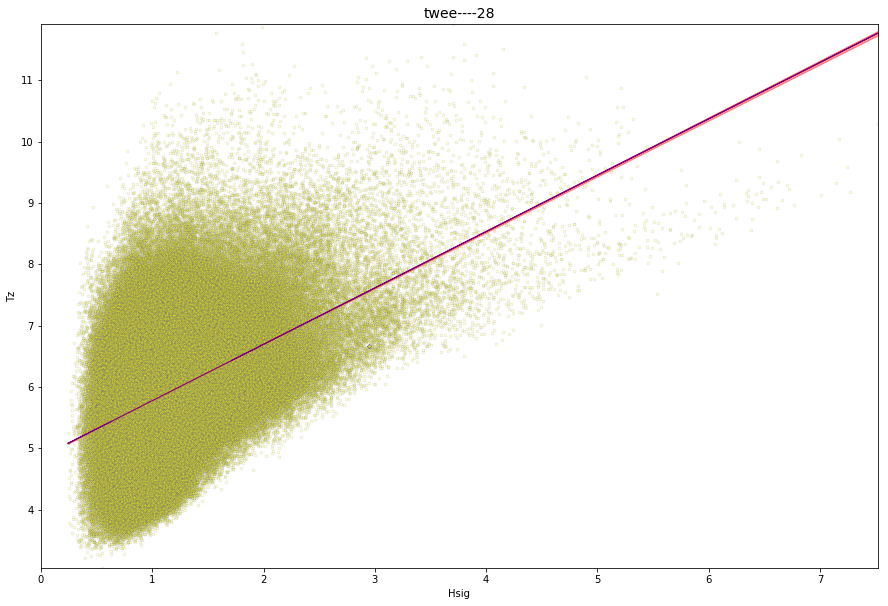

In [4]:
# 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

%matplotlib inline
  
x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)
    
fig,ax = plt.subplots(figsize=(15,10))
 
# do scatter plot of data
ax.plot(recs.Hsig,recs.Tz, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow', alpha=0.2)

# Perform linear regression
x1 = sm.add_constant(x.values)
y1 = recs.Tz
regr = sm.OLS(y1, x1)
res = regr.fit()

# Get fitted values from model to fit a linear plot 
# see https://tedboy.github.io/statsmodels_doc/generated/statsmodels.stats.outliers_influence.summary_table.html
st, data, ss2 = summary_table(res, alpha=0.05)
fitted_values = data[:,2]
plt.plot(x, fitted_values, lw = 1, color = 'r', alpha = 1)

# Get the confidence intervals of the model
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

# Data for regions where we want to shade to indicate the intervals has
# to be sorted by the x axis to display correctly
CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
CI_df['x_data'] = recs.Hsig
CI_df['low_CI'] = predict_mean_ci_low
CI_df['upper_CI'] = predict_mean_ci_upp
CI_df.sort_values('x_data', inplace = True)

# visualise the 95% confidence intervals
plt.plot(x,fitted_values,lw = 1,color = 'b', alpha = 0.5, label = 'Fit')
plt.fill_between(CI_df['x_data'],CI_df['low_CI'],CI_df['upper_CI'],color = 'r',alpha = 0.4, label = '95% CI')
plt.title(Site, fontsize=14)
plt.xlim(0,max(x))
plt.ylim(min(y),max(y))
plt.xlabel(x_val.split('.')[-1])
plt.ylabel(y_val.split('.')[-1])


slope: 0.919219    intercept: 4.858683
R-squared: 0.208285


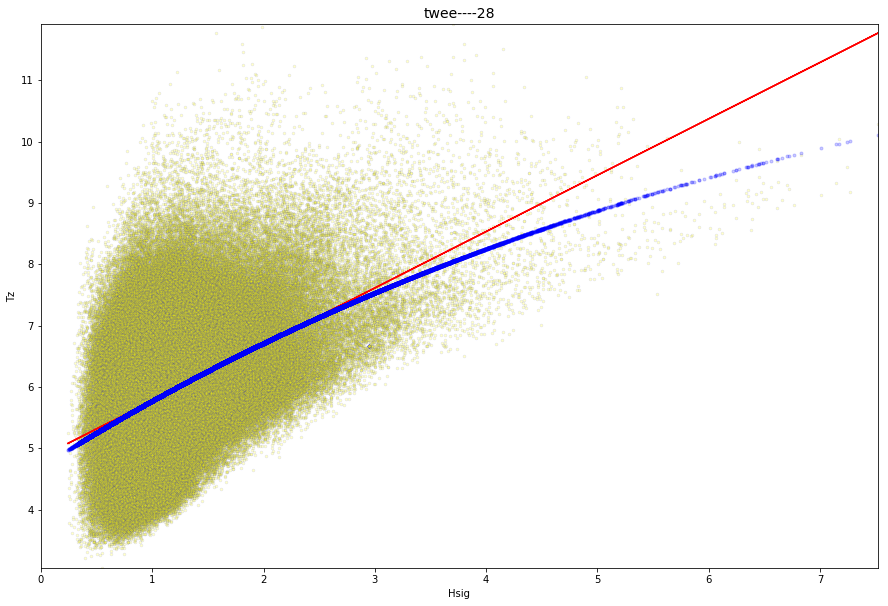

In [5]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))

print("R-squared: %f" % r_value**2)

plt.figure(figsize=(15,10))
plt.plot(x, y, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow', alpha=0.2)
plt.plot(x, intercept + slope*x, 'r')

popt, pcov = curve_fit(func, x, y)
plt.plot(x, func(x, *popt),marker='.',lw=0,c = 'b', alpha=0.2)
plt.title(Site, fontsize=14)
plt.xlim(0,max(x))
plt.ylim(min(y),max(y))
plt.xlabel(x_val.split('.')[-1])
plt.ylabel(y_val.split('.')[-1])

plt.show()

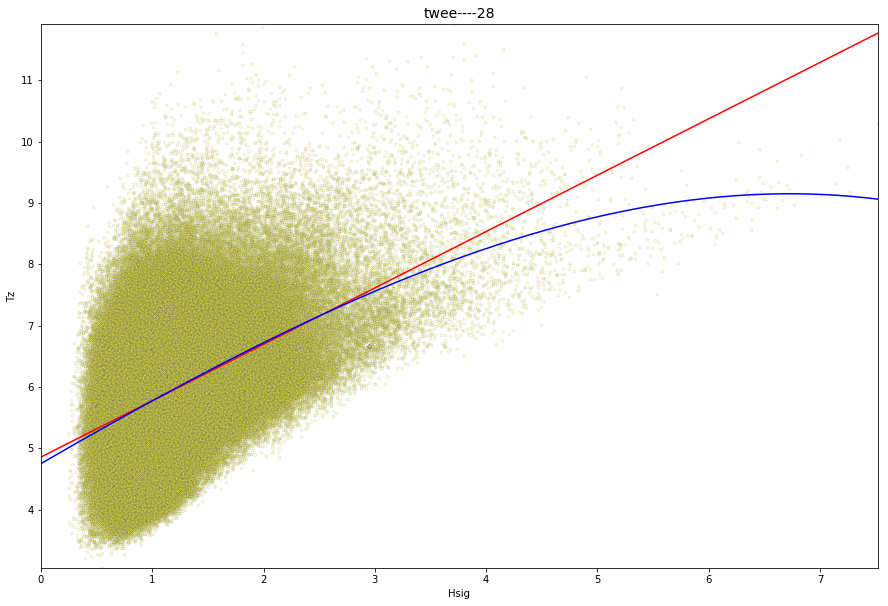

In [6]:
import warnings
import matplotlib.pyplot as plt

x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)

z1 = np.polyfit(x, y, 1)
z3 = np.polyfit(x, y, 3)

p1 = np.poly1d(z1)
p3 = np.poly1d(z3)

xp = np.linspace(0, max(x), 1000)

plt.figure(figsize=(15,10))
plt.plot(x, y, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow', alpha=0.2)

plt.plot(xp, p1(xp),c='r')
plt.plot(xp, p3(xp),c='b')
plt.title(Site, fontsize=14)
plt.xlim(0,max(x))
plt.ylim(min(y),max(y))
plt.xlabel(x_val.split('.')[-1])
plt.ylabel(y_val.split('.')[-1])

plt.show()

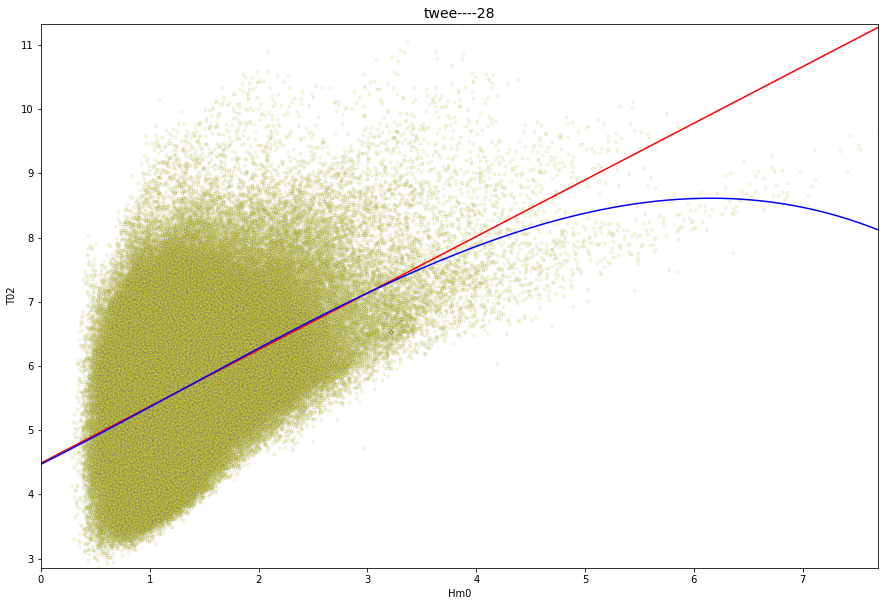

In [7]:
import matplotlib.pyplot as plt

x_val = 'recs.Hm0'
y_val = 'recs.T02'
x = eval(x_val)
y = eval(y_val)

z1 = np.polyfit(x, y, 1)
z3 = np.polyfit(x, y, 3)

p1 = np.poly1d(z1)
p3 = np.poly1d(z3)

xp = np.linspace(0, max(x), 1000)

plt.figure(figsize=(15,10))
plt.plot(x, y, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow', alpha=0.2)

plt.plot(xp, p1(xp),c='r')
plt.plot(xp, p3(xp),c='b')
plt.title(Site, fontsize=14)
plt.xlim(0,max(x))
plt.ylim(min(y),max(y))
plt.xlabel(x_val.split('.')[-1])
plt.ylabel(y_val.split('.')[-1])

plt.show()

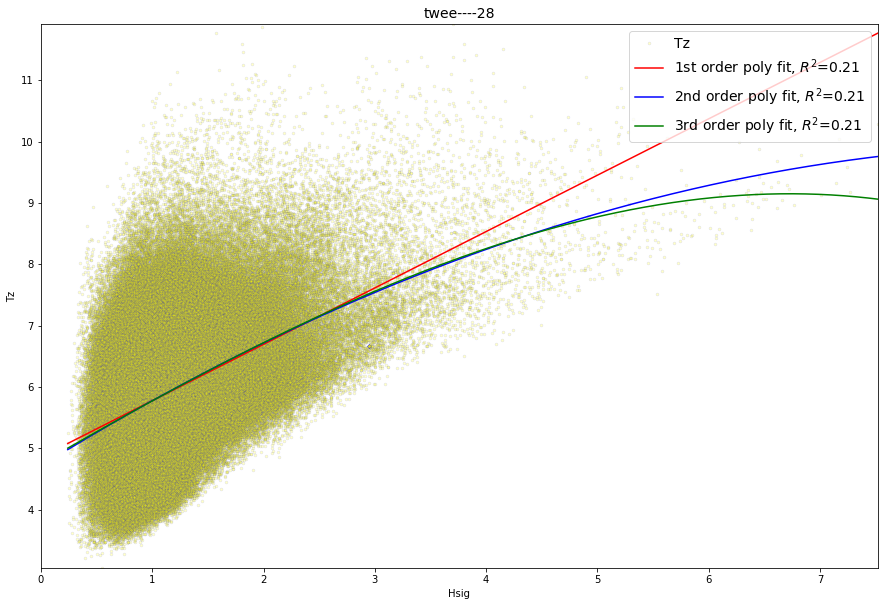

In [8]:
#  1st, 2nd, and 3rd-order polynomial linear regression, confidence and prediction intervals, and quantile regression.
# See http://inversionlabs.com/2016/02/07/using-quantile-regression.html

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline

x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)

plt.figure(figsize=(15,10))
plt.plot(x, y, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow', alpha=0.2)

df = pd.DataFrame({'predictor': x, 'response': y})
x1 = pd.DataFrame({'predictor': np.linspace(df.predictor.min(), df.predictor.max(), len(x))})

poly_1 = smf.ols(formula='response ~ 1 + predictor', data=df).fit()
poly_2 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0)', data=df).fit()
poly_3 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0) + I(predictor ** 3.0)', data=df).fit()
##print(poly_2.summary())

plt.plot(x1.predictor, poly_1.predict(x1), 'r-', 
         label='1st order poly fit, $R^2$=%.2f' % poly_2.rsquared)
plt.plot(x1.predictor, poly_2.predict(x1), 'b-', 
         label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared)
plt.plot(x1.predictor, poly_3.predict(x1), 'g-', 
         label='3rd order poly fit, $R^2$=%.2f' % poly_2.rsquared)

plt.legend(loc="upper right", fontsize=14)
plt.title(Site, fontsize=14)
plt.xlim(0,max(x))
plt.ylim(min(y),max(y))
plt.xlabel(x_val.split('.')[-1])
plt.ylabel(y_val.split('.')[-1])

plt.show()

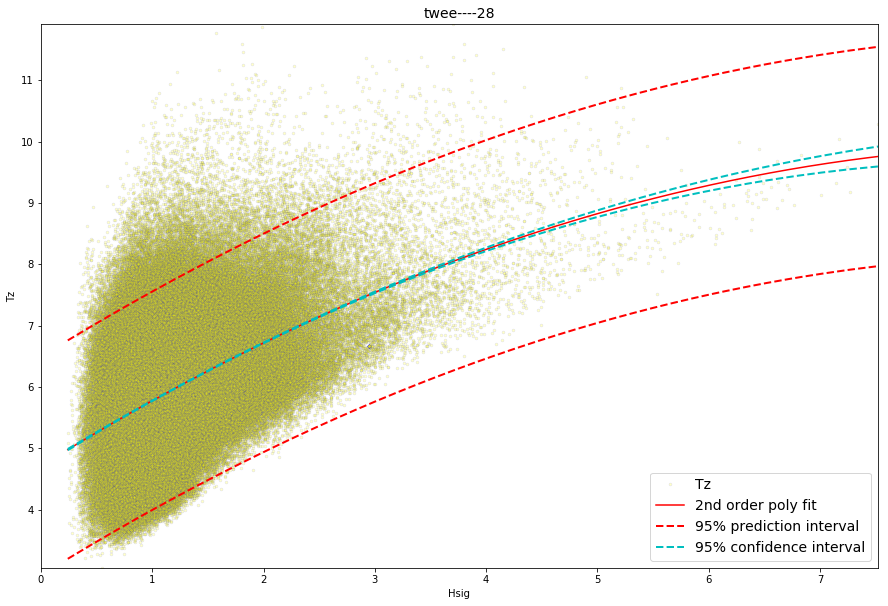

In [9]:
# CI and PI for 2nd order poly:

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std

x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)

plt.figure(figsize=(15,10))
plt.plot(x, y, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow', alpha=0.2)

df = pd.DataFrame({'predictor': x, 'response': y})
x1 = pd.DataFrame({'predictor': np.linspace(df.predictor.min(), df.predictor.max(), len(x))})

plt.plot(x1.predictor, poly_2.predict(x1), 'k-', c='r', label='2nd order poly fit')
##print(poly_2.summary())

prstd, iv_l, iv_u = wls_prediction_std(poly_2)

st, data, ss2 = summary_table(poly_2, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

# check we got the right things
#print np.max(np.abs(poly_2.fittedvalues - fittedvalues))
#print np.max(np.abs(iv_l - predict_ci_low))
#print np.max(np.abs(iv_u - predict_ci_upp))

data_intervals = {'predictor': x, 'predict_low': predict_ci_low, 'predict_upp': predict_ci_upp,
                  'conf_low': predict_mean_ci_low, 'conf_high': predict_mean_ci_upp}
df_intervals = pd.DataFrame(data=data_intervals)
df_intervals_sort = df_intervals.sort_values(by='predictor')

plt.plot(df_intervals_sort.predictor, df_intervals_sort.predict_low,
         color='r', linestyle='--', linewidth=2, label='95% prediction interval')
plt.plot(df_intervals_sort.predictor, df_intervals_sort.predict_upp,
         color='r', linestyle='--', linewidth=2, label='')
plt.plot(df_intervals_sort.predictor, df_intervals_sort.conf_low,
         color='c', linestyle='--', linewidth=2, label='95% confidence interval')
plt.plot(df_intervals_sort.predictor, df_intervals_sort.conf_high,
         color='c', linestyle='--', linewidth=2, label='')

plt.title(Site, fontsize=14)
plt.xlim(0,max(x))
plt.ylim(min(y),max(y))
plt.xlabel(x_val.split('.')[-1])
plt.ylabel(y_val.split('.')[-1])
plt.legend(fontsize=14)

plt.show()

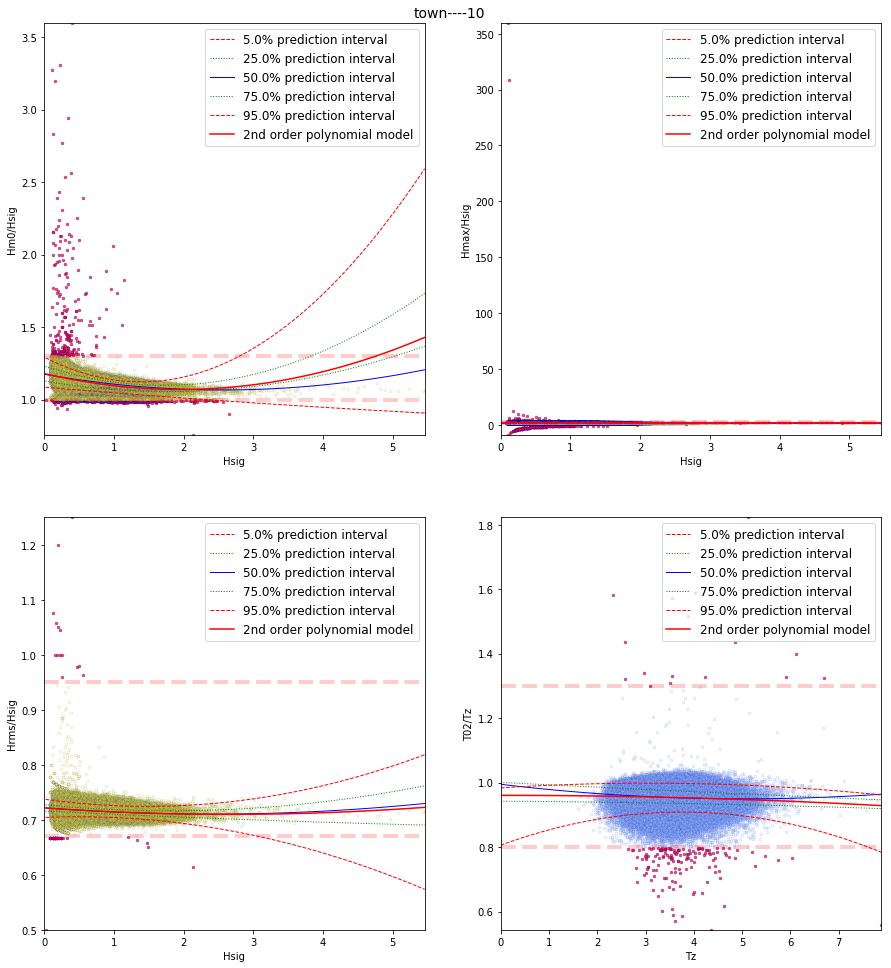

In [13]:
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

##################################################
def do_quantile_predictions(x,y):
    df = pd.DataFrame({'predictor': x, 'response': y})
    x1 = pd.DataFrame({'predictor': np.linspace(df.predictor.min(), df.predictor.max(), len(x))})

    mod = smf.quantreg('response ~ predictor + I(predictor ** 2.0)', df)

    # Quantile regression for 5 quantiles
    quantiles = [.05, .25, .50, .75, .95]

    # get all result instances in a list
    res_all = [mod.fit(q=q) for q in quantiles]
    res_ols = smf.ols('response ~ predictor + I(predictor ** 2.0)',df).fit()

    # create x for prediction
    x_p = np.linspace(df.predictor.min(),df.predictor.max(), 50)
    df_p = pd.DataFrame({'predictor': x_p})
    y_ols_predicted = res_ols.predict(df_p)

    return(x_p,y_ols_predicted,res_all,quantiles)

##################################################
def Do_plot(ax,x_val,y_val,x,y,x_p,y_ols_predicted,res_all,quantiles,lower_bound,upper_bound,plot_color):
#    ax.plot(x, y, marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = plot_color, alpha=0.2)

    ax.plot(x[~(y).between(lower_bound,upper_bound,inclusive=False)],y[~(y).between(lower_bound,upper_bound,inclusive=False)],
         marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'red', alpha=0.7)
    ax.plot(x[(y).between(lower_bound,upper_bound,inclusive=False)],y[(y).between(lower_bound,upper_bound,inclusive=False)],
         marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = plot_color, alpha=0.2)    
    # set up linestyle and color for quantiles
    linestyle=['--',':','-',':','--']
    color = ['r','g','b','g','r']

    ii=0
    for qm, res in zip(quantiles, res_all):
        # get prediction for the model and plot
        ax.plot(x_p, res.predict({'predictor': x_p}),lw=1,ls=linestyle[ii],c=color[ii],
                 label=str(qm*100)+'% prediction interval')
        ii+=1

    ax.plot(x_p, y_ols_predicted, color='red', label='2nd order polynomial model')

    # plot current checking bounds
    ax.plot([0,max(x)],[upper_bound,upper_bound],lw=4.0,c="r",ls='--', alpha=0.2)
    ax.plot([0,max(x)],[lower_bound,lower_bound],lw=4.0,c="r",ls='--', alpha=0.2)
    ax.set_xlim(0,max(x))
    ax.set_ylim(min(min(y),lower_bound*0.95),max(max(y),upper_bound*1.05))

# Get Y label from string name - cater for two parameters in string.
    try:
        y_label = (y_val.split('/')[-2].split('.')[-1])+'/'+(y_val.split('/')[-1].split('.')[-1])
    except:
        y_label = y_val.split('.')[-1]
    
    ax.set_xlabel(x_val.split('.')[-1])
    ax.set_ylabel(y_label)
    ax.legend(fontsize=12)
    
    return()

##################################################
# try to remove bad values from df before plotting
recs.replace([np.inf, -np.inf], np.nan)
recs.dropna(inplace=True)

# do plots
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,15), facecolor=(1, 1, 1))
fig.suptitle(Site,fontsize=14)
#fig.tight_layout()
fig.subplots_adjust(top=0.965)

x_val = 'recs.Hsig'
y_val = 'recs.Hm0/recs.Hsig'
x = eval(x_val)
y = eval(y_val)

# Calculate the quantile predictions for plotting bounds
x_p,y_ols_predicted,res_all,quantiles = do_quantile_predictions(x,y)
Do_plot(ax1,x_val,y_val,x,y,x_p,y_ols_predicted,res_all,quantiles,1.0,1.3,'yellow')

x_val = 'recs.Hsig'
y_val = 'recs.Hmax/recs.Hsig'
x = eval(x_val)
y = eval(y_val)
# Calculate the quantile predictions for plotting bounds
x_p,y_ols_predicted,res_all,quantiles = do_quantile_predictions(x,y)
Do_plot(ax2,x_val,y_val,x,y,x_p,y_ols_predicted,res_all,quantiles,1.4,2.5,'yellow')

x_val = 'recs.Hsig'
y_val = 'recs.Hrms/recs.Hsig'
x = eval(x_val)
y = eval(y_val)
# Calculate the quantile predictions for plotting bounds
x_p,y_ols_predicted,res_all,quantiles = do_quantile_predictions(x,y)
Do_plot(ax3,x_val,y_val,x,y,x_p,y_ols_predicted,res_all,quantiles,0.67,0.95,'yellow')

x_val = 'recs.Tz'
y_val = 'recs.T02/recs.Tz'
x = eval(x_val)
y = eval(y_val)
# Calculate the quantile predictions for plotting bounds
x_p,y_ols_predicted,res_all,quantiles = do_quantile_predictions(x,y)
Do_plot(ax4,x_val,y_val,x,y,x_p,y_ols_predicted,res_all,quantiles,0.8,1.3,'lightblue')

plt.show()

In [ ]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.plot_partregress_grid(poly_2, fig=fig)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.plot_ccpr_grid(poly_2, fig=fig)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(poly_2, 'predictor', fig=fig)

In [ ]:
# See https://zhiyzuo.github.io/Linear-Regression-Diagnostic-in-Python/

import pandas as pd
import statsmodels.formula.api as smf

x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)

# Perform linear regression
x1 = sm.add_constant(x.values)
y1 = y

reg = smf.ols('Hsig ~ Tz', data=recs).fit()
print(reg.summary())

pred_val = reg.fittedvalues.copy()
true_val = x
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(15,10))
_ = ax.scatter(residual, pred_val)

import statsmodels.stats.api as sms
sms.linear_harvey_collier(reg)

import scipy as sp
fig, ax = plt.subplots(figsize=(15,10))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

In [ ]:
import numpy as np
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

r, p, lo, hi = pearsonr_ci(recs.Hsig,recs.Tz,alpha=0.05)

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

x_val = 'recs.Hsig'
y_val = 'recs.Tz'
x = eval(x_val)
y = eval(y_val)

# Perform linear regression
x1 = sm.add_constant(x.values)
y1 = y

reg = smf.ols('Hsig ~ Tz', data=recs).fit()
print(reg.summary())

pred_val = reg.fittedvalues.copy()
true_val = x
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(15,10))
_ = ax.scatter(residual, pred_val)

import statsmodels.stats.api as sms
sms.linear_harvey_collier(reg)

import scipy as sp
fig, ax = plt.subplots(figsize=(15,10))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [ ]:
x_val = 'recs.Hsig'
y_val = 'recs.Hm0/recs.Hsig'
reg = smf.ols(x_val+' ~ '+y_val, data=recs).fit()

In [ ]:
pred_val = reg.fittedvalues.copy()
true_val = x
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(15,10))
_ = ax.scatter(residual, pred_val)

import statsmodels.stats.api as sms
sms.linear_harvey_collier(reg)

import scipy as sp
fig, ax = plt.subplots(figsize=(15,10))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [148]:
recs.loc[recs.Hrms/recs.Hsig > 1.1]

Hsig  Thsig  Hrms  Hmax    Tc   Tz  H10  Th10  Thmax  \
1989-09-17 03:15:00   1.0  10.21  1.11  -1.0  3.62  6.9 -1.0  -1.0   -1.0   

                     Tzmax   Hm0   T02     Tp   EPS  Npts  
1989-09-17 03:15:00   -1.0  1.64  3.48  11.49  0.78  2220

In [147]:
recs.loc[recs.Hm0/recs.Hsig < 0.8]

Hsig     Thsig      Hrms  Hmax        Tc        Tz  \
2008-11-03 10:00:00  0.457000  7.477426  0.370000  0.52  5.836552  5.983692   
2008-11-17 06:00:00  1.213559  5.767033  0.865457  1.85  4.639885  4.660788   

                          H10      Th10    Thmax      Tzmax       Hm0  \
2008-11-03 10:00:00  0.485000  7.479588  6.43500  10.562497  0.181372   
2008-11-17 06:00:00  1.496316  5.900003  5.74206   9.373117  0.962577   

                          T02        Tp  EPS  Npts  
2008-11-03 10:00:00  5.460601  7.557086  0.0  2048  
2008-11-17 06:00:00  4.399707  5.339741  0.0  2048